# ST446 Assignment 1

## P1 Spark RDDs

### P1.1 Loading data into an RDD (not assessed)

You need to load the data into an RDD consisting of string elements, each element corresponding to the text of a Wikipedia page. Precisely, each RDD element should be a string equal to the text enclosed within `<page>` and `</page>` XML tags in the input dataset with carriage-return characters (`\n`) removed. Show the first element of the RDD. Show the number of elements of this RDD.

In [1]:
# Wikipedia dump
# we use the enwiki-latest-pages-articles1.xml-p1p41242.bz2 dump
!wget https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles1.xml-p1p41242.bz2
# decompress the file
!bzip2 -d enwiki-latest-pages-articles1.xml-p1p41242.bz2
# rename the uncompressed file to an XML format
!mv enwiki-latest-pages-articles1.xml-p1p41242 enwiki-latest-pages-articles1.xml
# move to Hadoop Namenode
!hadoop fs -put enwiki-latest-pages-articles1.xml /

--2024-02-23 15:05:37--  https://dumps.wikimedia.org/enwiki/latest/enwiki-latest-pages-articles1.xml-p1p41242.bz2
Resolving dumps.wikimedia.org (dumps.wikimedia.org)... 208.80.154.71, 2620:0:861:3:208:80:154:71
Connecting to dumps.wikimedia.org (dumps.wikimedia.org)|208.80.154.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 276785341 (264M) [application/octet-stream]
Saving to: ‘enwiki-latest-pages-articles1.xml-p1p41242.bz2’

enwiki-latest-pages 100%[===================>] 263.96M  3.68MB/s    in 64s     

2024-02-23 15:06:41 (4.10 MB/s) - ‘enwiki-latest-pages-articles1.xml-p1p41242.bz2’ saved [276785341/276785341]



In [2]:
# adjust to reflect the cluster name and Hadoop masternode (IP port) of your cluster
path = "hdfs://st446-cluster-w04-m:8020/enwiki-latest-pages-articles1.xml"

In [3]:
# initial Dataframe
# pages are separated by <page> and </page>
df1 = spark.read.text(path, lineSep="</page>")
df1.limit(10).toPandas()

,value
0,"<mediawiki xmlns=""http://www.mediawiki.org/xml..."
1,\n <page>\n <title>Anarchism</title>\n ...
2,\n <page>\n <title>AfghanistanHistory</tit...
3,\n <page>\n <title>AfghanistanGeography</t...
4,\n <page>\n <title>AfghanistanPeople</titl...
5,\n <page>\n <title>AfghanistanCommunicatio...
6,\n <page>\n <title>AfghanistanTransportati...
7,\n <page>\n <title>AfghanistanMilitary</ti...
8,\n <page>\n <title>AfghanistanTransnationa...
9,\n <page>\n <title>AssistiveTechnology</ti...


In [4]:
# accessing RDD element attached to the Dataframe
rdd1 = df1.rdd

---

**Additional check (not necessary for the assessment but can give you a better idea of how the data (RDD) is structured)**

In [5]:
# numPartitions depend on the cluster machine being used
# for instance, N2 4 vCPUs will give you 8 partitions
rdd1.getNumPartitions()

8

In [6]:
# first element
rdd1.take(1)

[Row(value='<mediawiki xmlns="http://www.mediawiki.org/xml/export-0.10/" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:schemaLocation="http://www.mediawiki.org/xml/export-0.10/ http://www.mediawiki.org/xml/export-0.10.xsd" version="0.10" xml:lang="en">\n  <siteinfo>\n    <sitename>Wikipedia</sitename>\n    <dbname>enwiki</dbname>\n    <base>https://en.wikipedia.org/wiki/Main_Page</base>\n    <generator>MediaWiki 1.42.0-wmf.18</generator>\n    <case>first-letter</case>\n    <namespaces>\n      <namespace key="-2" case="first-letter">Media</namespace>\n      <namespace key="-1" case="first-letter">Special</namespace>\n      <namespace key="0" case="first-letter" />\n      <namespace key="1" case="first-letter">Talk</namespace>\n      <namespace key="2" case="first-letter">User</namespace>\n      <namespace key="3" case="first-letter">User talk</namespace>\n      <namespace key="4" case="first-letter">Wikipedia</namespace>\n      <namespace key="5" case="first-letter">Wikipedi

In [7]:
# RDD2: all rows containing <page>
rdd2 = rdd1.filter(lambda row: "<page>" in row[0])

In [8]:
# split RDD2 based on <page> and with no carriage returns
rdd2 = rdd2.map(lambda row: row[0].split("<page>")[1].replace("\n", ""))

In [9]:
# first element of RDD2
rdd2.take(1)

['    <title>AccessibleComputing</title>    <ns>0</ns>    <id>10</id>    <redirect title="Computer accessibility" />    <revision>      <id>1002250816</id>      <parentid>854851586</parentid>      <timestamp>2021-01-23T15:15:01Z</timestamp>      <contributor>        <username>Elli</username>        <id>20842734</id>      </contributor>      <minor />      <comment>shel</comment>      <model>wikitext</model>      <format>text/x-wiki</format>      <text bytes="111" xml:space="preserve">#REDIRECT [[Computer accessibility]]{{rcat shell|{{R from move}}{{R from CamelCase}}{{R unprintworthy}}}}</text>      <sha1>kmysdltgexdwkv2xsml3j44jb56dxvn</sha1>    </revision>  ']

---

**Additional check (not necessary for the assessment but can give you a better idea of how the data (RDD) is structured)**

In [10]:
# number of elements in RDD2
rdd2.count()

27376

---

**All the remaining questions can be answered based on this initial RDD (`rdd2`)**

In [11]:
# Importing the libraries 
import re
import numpy as np
from math import log2
from datetime import datetime
import matplotlib.pyplot as plt
from collections import defaultdict

from pyspark.sql import Row
from pyspark.sql.functions import year, month
from pyspark.sql.functions import explode, col, count, desc
from pyspark.sql.functions import size, split
from pyspark.sql.types import StructType, StructField, LongType, StringType, ArrayType, TimestampType

### P1.2 Number of categories per page

Task: Some Wikipedia pages contain information about categories to which they belong. For those Wikipedia pages, there can be one or more categories indicated in the Wikipedia dump file. Create a key-value pair RDD with keys corresponding to page IDs and values corresponding to the number of categories of the corresponding page (both Integer type).

Output: Show the key-value pairs of this pair RDD for the top 10 elements in decreasing order of values.

Example: [('19856', 233), ('6198', 230),...

In [12]:
def extract_info(text):
    page_id = re.search('<id>(\d+)</id>', text)
    page_id = page_id.group(1) if page_id else '0'
    categories = re.findall('\[\[Category:(.*?)\]\]', text)
    return (page_id, len(categories))

page_categories = rdd2.map(extract_info)

top_categories = page_categories.filter(lambda x: x[1] > 0) \
                                              .takeOrdered(10, key=lambda x: -x[1])

top_categories

[('19856', 233),
 ('6198', 230),
 ('32753', 221),
 ('22107', 218),
 ('16775', 215),
 ('31898', 214),
 ('6201', 213),
 ('32124', 208),
 ('31940', 198),
 ('7851', 181)]

- In the code (P1.2), I created a function `extract_info` that takes in text, and finds `id` and `category` using regex. 
- I then mapped the function to the rdd2 created in P1.1
- Before printing the `top_categories`, I filtered the data using a lambda function to remove the page_id where category count is 0.  

### P1.3 Top contributors

Task: In this exercise, we analyse the amount of contributions made by contributors in terms of the number of page revisions. Create a key-value pair RDD with keys corresponding to page IDs and the value corresponding to contributor IDs.

Create another key-value pair RDD with keys corresponding to contributor IDs and values corresponding to contributor names. Use these two pair RDDs to compute a third key-value pair RDD with keys corresponding to contributor IDs and values corresponding to a tuple with the first element corresponding to the number of pages revised by the contributor and the second element corresponding to the contributor's name.

Note: filter out pages for which the username and ID of the contributor are not specified.

Output: Show the top 10 elements of this third RDD in decreasing order of the number of pages revised by the contributor.

Example: [(9784415, (1140, 'Tom.Reding')), (7903804, (1137, 'Citation bot')),...

In [58]:
def extract_info(text):
    page_id = re.search('<id>(\d+)</id>', text)
    contributor_id = re.search('<contributor>.*?<id>(\d+)</id>', text, re.DOTALL)
    username = re.search('<username>(.*?)</username>', text)
    
    if page_id and contributor_id and username:
        return (page_id.group(1), contributor_id.group(1), username.group(1))
    else:
        return None

mapped_rdd = rdd2.map(extract_info) \
                                     .filter(lambda x: x is not None)

# Map to (ContributorID, 1) for counting and (ContributorID, Username) for names
contrib_count = mapped_rdd.map(lambda x: (x[1], 1)).reduceByKey(lambda a, b: a + b)
contrib_names = mapped_rdd.map(lambda x: (x[1], x[2])).distinct()

# Join counts with names and sort by counts in descending order
contrib_summary = contrib_count.join(contrib_names).map(lambda x: (x[0], x[1][1], x[1][0]))

top_contributors = contrib_summary.map(lambda x: (x[0], (x[2], x[1]))).sortBy(lambda x: -x[1][0]).take(10)

print(top_contributors)

[('7903804', (1266, 'Citation bot')), ('9784415', (1204, 'Tom.Reding')), ('194203', (432, 'Graham87')), ('20836525', (395, '1234qwer1234qwer4')), ('212624', (362, 'MZMcBride')), ('27015025', (355, 'InternetArchiveBot')), ('27823944', (275, 'GreenC bot')), ('44120587', (266, 'HeyElliott')), ('8066546', (232, 'Xqbot')), ('35936988', (203, 'JJMC89 bot III'))]


- In the code above (P1.3), the `extract_info` function extracts `id`, `contributor` and `username` from the text inputted. 
- The function is mapped on to the rdd2, and None values are filtered out as well. 
- Then, we count how many times each contributor has made revisions and associate these counts with their names. 
- Finally, the contributors are ranked by their number of contributions, displaying the top 10 contributors along with their IDs and the number of pages they've revised.

### P1.4 Effective number of categories per contributor

Output 2: Plot the entropy (y-axis) versus the total number of revisions per contributor (x-axis) (use log-scale for x-axis).


In [70]:
def extract_info(text):
    contributor_id = None
    categories = []
    
    # Etracting contributor ID and username
    contributor_match = re.search(r'<contributor>\s*<username>(.+?)</username>\s*<id>(\d+)</id>\s*</contributor>', text)
    if contributor_match:
        contributor_id = int(contributor_match.group(2))
    
    # Extract categories
    category_matches = re.findall(r'\[\[Category:(.*?)\]\]', text)
    categories = [match for match in category_matches]
    
    # Create list of tuples (contributor_id, category)
    result = [(contributor_id, category) for category in categories]
    
    return result

contributor_categories_rdd = rdd2.flatMap(extract_info) \
                                .filter(lambda x: x[0] is not None) \
                                 .map(lambda x: ((x[0], x[1]), 1)) \
                                 .reduceByKey(lambda a, b: a + b) \
                                 .map(lambda x: (x[0][0], (x[0][1], x[1])))


In [71]:
# Function to calculate entropy
def calculate_entropy(counts):
    total_revisions = sum(counts)
    entropy = sum((-count / total_revisions) * log2(count / total_revisions) for count in counts)
    return entropy

# Create a new key-value pair RDD with the desired elements
contributor_summary_rdd = contributor_categories_rdd \
    .map(lambda x: (x[0], (x[1][1], {x[1][0]}))) \
    .reduceByKey(lambda a, b: (a[0] + b[0], a[1].union(b[1])), numPartitions=10) \
    .mapValues(lambda x: (x[0], len(x[1]), calculate_entropy([1] * x[0])))

In [72]:
# Output 1

contributor_summary_rdd.take(10)

[(14124830, (6, 6, 2.584962500721156)),
 (47398990, (9, 9, 3.169925001442312)),
 (15474270, (9, 9, 3.169925001442312)),
 (29463730, (331, 330, 8.370687406807162)),
 (41588820, (6, 6, 2.584962500721156)),
 (33146470, (42, 42, 5.3923174227787625)),
 (44217690, (34, 34, 5.087462841250338)),
 (372290, (351, 347, 8.455327220304579)),
 (481360, (81, 78, 6.339850002884614)),
 (1760580, (63, 63, 5.97727992349992))]

- In P1.4, we analysed categories of Wikipedia pages revised by contributors. 
- Created a key-value pair RDD with keys corresponding to contributor IDs and values being tuples with the first element as page category and the second element as the number of revisions the contributor made to the category.
- Using this pair RDD, created a new key-value pair RDD with keys corresponding to contributor IDs and values corresponding to a list with: 
    - (1) the first element being the total number of revisions made by the contributor
    - (2) the second element being the number of distinct categories for which the contributor made at least one revision
    - (3) the third element being the entropy of the distribution of the number of revisions over categories.
- Showed the top 10 elements of sorted elements with respect to the total number of revisions per contributor.

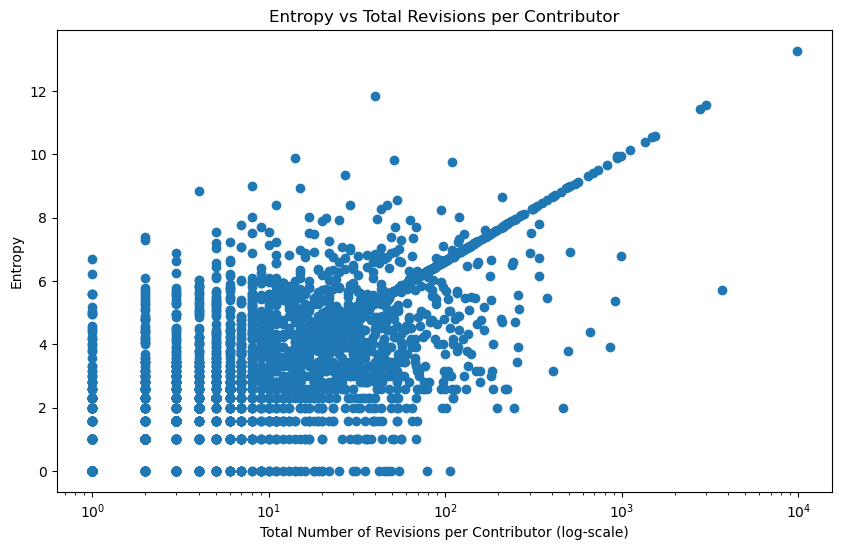

In [73]:
# Output 2: Plot the entropy versus the total number of revisions per contributor

# Extracting data for plotting
total_revisions = contributor_summary_rdd.map(lambda x: x[1][0]).collect()
entropy = contributor_summary_rdd.map(lambda x: x[1][2]).collect()

# Plotting
plt.figure(figsize=(10, 6))
plt.scatter(total_revisions, entropy)
plt.xlabel('Total Number of Revisions per Contributor (log-scale)')
plt.ylabel('Entropy')
plt.xscale('log')
plt.title('Entropy vs Total Revisions per Contributor')
plt.show()

## P2 Spark Dataframes 

### P2.1 Creating a dataframe

In [74]:
schema = StructType([
    StructField("page_id", LongType(), True),
    StructField("title", StringType(), True),
    StructField("contributor", ArrayType(StructType([
        StructField("id", LongType(), True),
        StructField("username", StringType(), True)
    ])), True),
    StructField("categories", ArrayType(StringType()), True),  # Placeholder for now
    StructField("revision_ts", TimestampType(), True)
])


def parse_page(page_xml):
    page_id = re.search(r'<id>(\d+)</id>', page_xml).group(1)
    title = re.search(r'<title>(.*?)</title>', page_xml).group(1)
    contributor_id = re.search(r'<contributor>.*?<id>(\d+)</id>', page_xml, re.DOTALL)
    contributor_username = re.search(r'<username>(.*?)</username>', page_xml)
    categories = re.findall(r'\[\[Category:(.*?)\]\]', page_xml)
    revision_ts = re.search(r'<timestamp>(.*?)</timestamp>', page_xml)
    
    contributor = [{'id': int(contributor_id.group(1)), 'username': contributor_username.group(1)}] if contributor_id and contributor_username else []
    revision_ts = datetime.strptime(revision_ts.group(1), '%Y-%m-%dT%H:%M:%SZ') if revision_ts else None
    
    return Row(page_id=int(page_id), title=title, contributor=contributor, categories=categories, revision_ts=revision_ts)

# Apply parsing function to rdd2 and create DataFrame
df = spark.createDataFrame(rdd2.map(parse_page), schema)

df.printSchema()


root
 |-- page_id: long (nullable = true)
 |-- title: string (nullable = true)
 |-- contributor: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- username: string (nullable = true)
 |-- categories: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- revision_ts: timestamp (nullable = true)



- Created a Dataframe with the following specification.
    - Col 1 - name: page_id, type: LongType
    - Col 2 - name: title, type: StringType 
    - Col 3 - name: contributor, type: List(contributor id: LongType, username: StringType) 
    - Col 4 - name: categories, type: ArrayType(elementType = StringType)
    - Col 5 - name: revision_ts, type: TimestampType
- Defined the schema and then loaded the data (from the initial RDD (rdd2)) into this Dataframe.

In [75]:
df.show(10)

+-------+--------------------+--------------------+--------------------+-------------------+
|page_id|               title|         contributor|          categories|        revision_ts|
+-------+--------------------+--------------------+--------------------+-------------------+
|     10| AccessibleComputing|  [{20842734, Elli}]|                  []|2021-01-23 15:15:01|
|     12|           Anarchism|    [{244263, Czar}]|[Anarchism| , Ant...|2024-02-17 15:33:05|
|     13|  AfghanistanHistory|[{9784415, Tom.Re...|                  []|2017-06-05 04:18:18|
|     14|AfghanistanGeography|[{9784415, Tom.Re...|                  []|2017-06-05 04:18:23|
|     15|   AfghanistanPeople|[{9784415, Tom.Re...|                  []|2017-06-05 04:19:42|
|     18|AfghanistanCommun...|[{9784415, Tom.Re...|                  []|2017-06-05 04:19:45|
|     19|AfghanistanTransp...|[{9784415, Tom.Re...|                  []|2017-06-04 21:42:11|
|     20| AfghanistanMilitary|  [{8066546, Xqbot}]|                  [

In [76]:
print(f"Count of rows: {df.count()}")

Count of rows: 27376


In [77]:
print(f"Number of partitions: {df.rdd.getNumPartitions()}")

Number of partitions: 8


### P2.2 Page Title Lengths 

In [129]:
# Add a new column "title_length" to df that represents the number of words in the title
df_with_title_length = df.withColumn("title_length", size(split(col("title"), " ")))

# Show top 10 rows sorted by title_length in descending order
df_with_title_length.select("page_id", "title_length").orderBy(col("title_length").desc()).show(10)


+-------+------------+
|page_id|title_length|
+-------+------------+
|  28066|          14|
|  25165|          14|
|   6199|          13|
|   6202|          13|
|  30702|          13|
|  28042|          12|
|  31293|          11|
|   4139|          11|
|  13458|          11|
|  18717|          11|
+-------+------------+
only showing top 10 rows



- Computed a Dataframe with the first column corresponding to page ID and the second column corresponding to page title length (in the number of words).
- Showed the top 10 rows of sorted Dataframe in decreasing order of page title lengths. 

In [130]:
# Aggregate to get the count of pages for each title length
title_length_distribution = (df_with_title_length
                             .groupBy("title_length")
                             .count()
                             .orderBy("title_length")
                             .collect())

# Extract title lengths and counts
title_lengths, counts = zip(*[(row['title_length'], row['count']) for row in title_length_distribution])
cumulative_counts = np.cumsum(counts[::-1])[::-1]

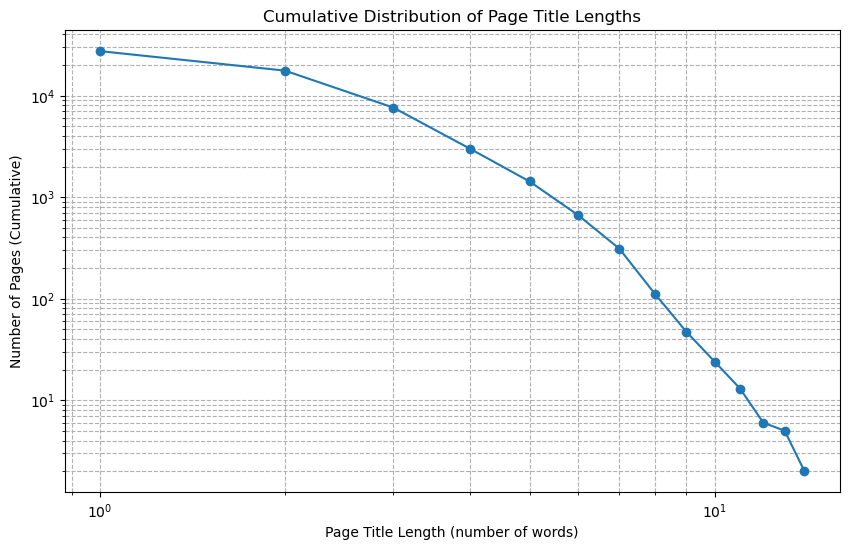

In [131]:
plt.figure(figsize=(10, 6))
plt.plot(title_lengths, cumulative_counts, marker='o')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Page Title Length (number of words)')
plt.ylabel('Number of Pages (Cumulative)')
plt.title('Cumulative Distribution of Page Title Lengths')
plt.grid(True, which="both", ls="--")
plt.show()


The plot shows the page title length on the x-axis and number of pages with the title length greater than the title length on the y-axis. In the plot, we can observe that there are more number of pages with lesser number of words. As the page title length increases, the number of pages decreases. There seems to be an almost linear relationship in the plot. This trend suggests that shorter titles are more common or preferred for Wikipedia pages, possibly for clarity or conciseness. Note that both the x and y values are log-scaled. 

### P2.3 Content edits over time 

In [25]:
# Group by revision timestamp and count the occurrences, which represent the number of pages edited at each timestamp
pages_per_revision = df.groupBy("revision_ts").count().orderBy(desc("count"))

# Show the top 20 rows as per the task requirement
pages_per_revision.show(20)

+-------------------+-----+
|        revision_ts|count|
+-------------------+-----+
|2002-02-25 15:51:15|   70|
|2002-02-25 15:43:11|   29|
|2022-07-24 04:23:37|    8|
|2021-01-04 12:08:13|    7|
|2021-01-04 12:08:11|    6|
|2021-01-04 12:08:14|    5|
|2024-02-19 18:30:13|    5|
|2021-01-04 12:08:12|    5|
|2021-08-31 20:08:13|    5|
|2024-02-17 19:29:35|    4|
|2024-02-07 16:07:10|    3|
|2024-02-19 18:29:01|    3|
|2023-12-21 15:58:20|    3|
|2022-09-24 13:34:32|    3|
|2024-02-19 17:41:52|    3|
|2021-01-04 12:08:15|    3|
|2024-02-04 05:10:21|    2|
|2024-02-16 21:10:22|    2|
|2024-02-18 18:03:20|    2|
|2024-02-15 23:45:24|    2|
+-------------------+-----+
only showing top 20 rows



- Computed the number of pages per revision timestamp sorted in decreasing order of the number of pages.
- Showed the top 20 rows.

In [26]:
# Extract the year from each timestamp, group by this year, count the occurrences, and sort by year in ascending order
pages_per_year = df.withColumn("year", year("revision_ts")).groupBy("year").count().orderBy(col("year").asc())

pages_per_year.show(20)


+----+-----+
|year|count|
+----+-----+
|2002|  238|
|2003|  161|
|2004|  168|
|2005|  186|
|2006|  227|
|2007|  116|
|2008|  130|
|2009|  165|
|2010|  193|
|2011|  125|
|2012|  434|
|2013|   97|
|2014|   91|
|2015|   79|
|2016|  111|
|2017| 1298|
|2018|  376|
|2019|  256|
|2020|  701|
|2021|  591|
+----+-----+
only showing top 20 rows



- Computed the number of pages per year, sorted in increasing order of years.
- Showed the top 20 rows.

### P2.4 Number of categories versus text length

In [134]:
def parse_page_to_get_length(page_xml):
    page_id_match = re.search(r'<id>(\d+)</id>', page_xml)
    text_match = re.search(r'<text.*?>(.+?)</text>', page_xml, re.DOTALL)
    page_id = int(page_id_match.group(1)) if page_id_match else None
    text_length = len(text_match.group(1).replace("\n", " ")) if text_match else 0  # Remove new lines and calculate length
    return (page_id, text_length)

page_text_lengths_rdd = rdd2.map(parse_page_to_get_length)
page_text_lengths_df = spark.createDataFrame(page_text_lengths_rdd, ["page_id", "text_length"])

# Add a column for the number of categories to df
df_with_categories = df.withColumn("num_categories", size(col("categories")))

# Join the DataFrames on page_id
combined_df = df_with_categories.join(page_text_lengths_df, "page_id")

combined_df.select("num_categories", "text_length").orderBy(col("text_length").desc()).show(20)


+--------------+-----------+
|num_categories|text_length|
+--------------+-----------+
|            61|     479367|
|            19|     476059|
|             4|     450415|
|             2|     439967|
|            21|     416685|
|            22|     415893|
|             5|     414526|
|            41|     413530|
|             1|     410322|
|            19|     408817|
|            13|     403679|
|            13|     403039|
|             4|     393390|
|             5|     385529|
|             4|     381997|
|            42|     378987|
|            18|     376022|
|             7|     374809|
|             2|     367925|
|             6|     365744|
+--------------+-----------+
only showing top 20 rows



- Created a new Dataframe with two columns: the first column corresponding to the number of page categories and the second column corresponding to the page text length.
- Showed the top 20 rows of this table sorted in decreasing order of page text lengths.

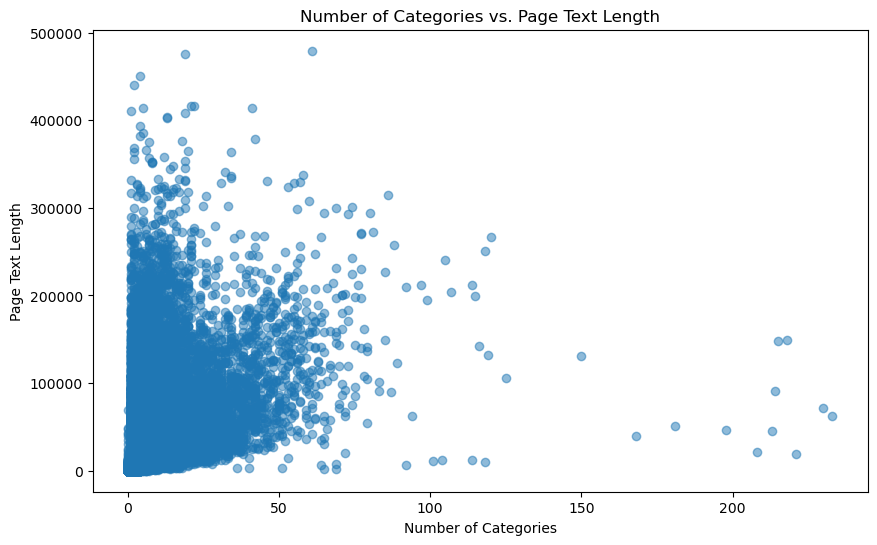

In [138]:
# Collect data for plotting
plot_data = combined_df.select("num_categories", "text_length").collect()

# Prepare data for the plot
num_categories = [row['num_categories'] for row in plot_data]
text_length = [row['text_length'] for row in plot_data]

plt.figure(figsize=(10, 6))
plt.scatter(num_categories, text_length, alpha=0.5)
plt.xlabel('Number of Categories')
plt.ylabel('Page Text Length')
plt.title('Number of Categories vs. Page Text Length')
plt.show()

- Showed the plot of the number of categories versus the page text length.

## P3 Spark SQL and Dataframes 

### P3.1 A Spark SQL range query 

In [140]:
df.createOrReplaceTempView("page_revisions")

# OUTPUT 1 

query = """
SELECT *
FROM page_revisions
WHERE year(revision_ts) = 2023 AND month(revision_ts) = 1
ORDER BY revision_ts DESC
LIMIT 20
"""
result = spark.sql(query)
result.show()


+-------+--------------------+--------------------+--------------------+-------------------+
|page_id|               title|         contributor|          categories|        revision_ts|
+-------+--------------------+--------------------+--------------------+-------------------+
|  25296|                Quid|[{40908735, Caleb...|                  []|2023-01-31 22:53:45|
|   5334|Telecommunication...|[{211905, Bruce1ee}]|[Telecommunicatio...|2023-01-31 17:14:34|
|   3681|Telecommunication...|[{211905, Bruce1ee}]|[Telecommunicatio...|2023-01-31 17:13:41|
|   5453|Telecommunication...|[{211905, Bruce1ee}]|[Telecommunicatio...|2023-01-31 17:11:35|
|  27314|Telecommunication...|[{211905, Bruce1ee}]|[Telecommunicatio...|2023-01-31 15:51:17|
|  12192|Telecommunication...|[{211905, Bruce1ee}]|[Telecommunicatio...|2023-01-31 15:41:34|
|  12162|Telecommunication...|[{211905, Bruce1ee}]|[Communications i...|2023-01-31 15:40:43|
|  12033|Telecommunication...|[{211905, Bruce1ee}]|[Telecommunicatio..

- Created a temporary view for the Dataframe created in P2.1.
- Spark SQL query to select rows which correspond to pages that were revised in January of 2023, ordered by revision time in decreasing order. 
- Showed top 20 rows.

In [32]:
# OUTPUT 2 

query_2 = """
SELECT COUNT(*) as count
FROM page_revisions
WHERE year(revision_ts) = 2023 AND month(revision_ts) = 1
"""
result = spark.sql(query)
result.show()

+-----+
|count|
+-----+
|  107|
+-----+



- Spark SQL query to count the number of pages that were revised in January 2023. 
- Showed the count.

### P3.2 Categories again 

In [36]:
# Define df1 as df
df1 = df

# Task 1
# Explode the 'categories' array column to create a new row for each category
exploded_df = df1.select(explode("categories").alias("category"))

# Group by category and count the number of pages per distinct category
category_counts_df = exploded_df.groupBy("category").agg(count("*").alias("page_count"))

# Sort the DataFrame by page_count in descending order
sorted_category_counts_df = category_counts_df.orderBy(desc("page_count"))

# Show the top 20 rows
sorted_category_counts_df.show(20)


+----------------------------------------------------+----------+
|category                                            |page_count|
+----------------------------------------------------+----------+
|Articles containing video clips                     |616       |
|Living people                                       |582       |
|Days of the year                                    |445       |
|20th-century American male writers                  |193       |
|Popes                                               |165       |
|Year of birth unknown                               |154       |
|Member states of the United Nations                 |137       |
|20th-century American novelists                     |128       |
|American male novelists                             |117       |
|Members of the American Philosophical Society       |117       |
|American male non-fiction writers                   |114       |
|Italian popes                                       |111       |
|American 

- Used the Dataframe defined in P2.1 as input.
- Explode the 'categories' array column to create a new row for each category
- Defined a Dataframe with two columns: the first column has distinct categories in df1, and the second column has the number of pages per distinct category. 
- Rows are sorted by page_count in descending order
- Printed the top 20 rows.

In [39]:
# Define df1 as df
df1 = df

# Explode the 'categories' array column to create a new row for each category
exploded_df2 = df1.select("page_id", explode("categories").alias("category"))

# Create a temporary view for the DataFrame df2
exploded_df2.createOrReplaceTempView("wiki_cat")

# Output 2
# Display the DataFrame df2 with columns page_id and category
exploded_df2.show()


+-------+-------------------------------+
|page_id|category                       |
+-------+-------------------------------+
|12     |Anarchism|                     |
|12     |Anti-capitalism                |
|12     |Anti-fascism                   |
|12     |Economic ideologies            |
|12     |Far-left politics              |
|12     |Left-wing politics             |
|12     |Libertarian socialism          |
|12     |Libertarianism                 |
|12     |Political culture              |
|12     |Political ideologies           |
|12     |Political movements            |
|12     |Social theories                |
|12     |Socialism                      |
|25     |1910s neologisms               |
|39     |Land surface effects on climate|
|39     |Climate change feedbacks       |
|39     |Climate forcing                |
|39     |Climatology                    |
|39     |Electromagnetic radiation      |
|39     |Meteorological quantities      |
+-------+-------------------------

- A new Dataframe df2 is created with two columns: the first column has page ID and the second has the category of the page. 
- Exploded the 'categories' array column to create a new row for each category
- Created a temporary view for a table with the name wiki_cat using df2.
- Wrote a SQL query to count the number of pages per category. 
- Then, printed the results in decreasing order of this count.

### P3.3 Saving the table 

In [142]:
# Assuming df is your DataFrame from P2.1
df_with_date_parts = df \
    .withColumn("ts_year", year("revision_ts")) \
    .withColumn("ts_month", month("revision_ts"))

df_with_date_parts.write.partitionBy("ts_year", "ts_month") \
    .mode("overwrite") \
    .saveAsTable("wikipersisted")

# OUTPUT 1 
df_wikipersisted = spark.read.table("wikipersisted")
df_wikipersisted.show(20)

+-------+--------------------+--------------------+--------------------+-------------------+-------+--------+
|page_id|               title|         contributor|          categories|        revision_ts|ts_year|ts_month|
+-------+--------------------+--------------------+--------------------+-------------------+-------+--------+
|  15665|  Economy of Jamaica|[{372290, Nikkima...|[Economy of Jamai...|2024-02-02 00:46:55|   2024|       2|
|  15673|           Jan Mayen|[{27015025, Inter...|[Jan Mayen| , 161...|2024-02-11 02:10:03|   2024|       2|
|  15683|       Jarvis Island|[{35936988, JJMC8...|[Jarvis Island| ,...|2024-02-10 22:34:30|   2024|       2|
|  15696|Demography of Jersey|[{17216044, RMCD ...|[Demographics of ...|2024-02-01 02:37:20|   2024|       2|
|  15697|  Politics of Jersey|[{7611264, Anomie...|[Politics of Jers...|2024-02-07 11:25:22|   2024|       2|
|  15698|   Economy of Jersey|[{25082147, Mazew...|[Economy of Jerse...|2024-02-13 18:05:45|   2024|       2|
|  15704| 

- Used the Dataframe defined in P2.1 as input. Created a new Dataframe with two columns: `ts_year` has the year of revision time and `ts_month` has the month of revision time.
- Saved this Dataframe to a table with the name wikipersisted using ts_year and ts_month as partitioning columns and using overwrite mode.
- Read the table wikipersisted using spark.read.table to a Dataframe.
- Showed the top 20 rows of this Dataframe.

In [143]:
# OUTPUT 2 
spark.sql("DESCRIBE EXTENDED wikipersisted").show(30)

+----------------------------+--------------------------------------------------------------+-------+
|col_name                    |data_type                                                     |comment|
+----------------------------+--------------------------------------------------------------+-------+
|page_id                     |bigint                                                        |null   |
|title                       |string                                                        |null   |
|contributor                 |array<struct<id:bigint,username:string>>                      |null   |
|categories                  |array<string>                                                 |null   |
|revision_ts                 |timestamp                                                     |null   |
|ts_year                     |int                                                           |null   |
|ts_month                    |int                                                 

- The output table gives detailed information about the stucture and metadata of the 'wikipersisted' table in Spark SQL. 
- The columns of the tables are `page_id`, `title`, `contributor`, `categories`, `revision_ts`, `ts_year` and `ts_month`.
    - `contributor` is an array of structs with `id` and `username`. 
    - `categories` is an array of strings. 
- The partition infromation section tells us that the table is partitioned on `ts_year` and `ts_month`. 
- In the detailed Table Information: 
    - Database is where the table resides. 
    - Name of table is `wikipersisted`.
    - Owner is the root. 
    - Created Time has the timestamp of when it was created. 
    - The Last access information is not known here. 
    - When the `Type` is `MANAGED`, it means that Spark manages the data and the metadata. 
    - Created By version of Spark 3.3.2
    - Provider is the format of the stored data. parquet in this case, which is a columnar storage format.
    - `Location` is the HDFS path where the table data is stored.
    - `Serde Library`, where SerDe stands for Serializer/Deserializer, tells how Hive reads and writes data in Parquet format. 
    - `InputFormat`, `OutputFormat` tell us that they are parquet supported. 
    - `Partition Provider` tells us that Spark catalog manages partition metadata.


### Marking scheme

| Problem breakdown | Max points |
|--------------| :----------:|
| P1-1 - Create an RDD from an XML file | 0 |
| P1-2 - RDD operations | 5 |
| P1-3 - RDD operations | 10 |
| P1-4 - RDD operations  | 15 |
| P2-1 - Create Dataframe, schema, loading data | 10 |
| P2-2 - Dataframe operations | 10 |
| P2-3 - Dataframe operations | 10 |
| P2-4 - Dataframe operations | 10 |
| P3-1 - Spark SQL queries  | 10 |
| P3-2 - Spark SQL queries | 10 |
| P3-3 - Spark SQL persisting tables | 10 |
| Total | 100 |

---